In [1]:
import torch
from torch import nn
from dataset import yolo_dataset
from model import YOLO
from create_dataset import create_image
from torchvision import transforms
from matplotlib.pyplot import imshow
from torch.functional import F
from PIL import Image, ImageDraw

In [2]:
ch = torch.load('./models/checkpoint_9_epochs.pth', map_location=torch.device('cpu'))
model = YOLO(ch['S'], ch['C'], ch['B'], ch['IMG_SIZE'], ch['architecture_config'])
print (model.load_state_dict(ch['state_dict']))

transformer = transforms.Compose([
    transforms.Resize((ch['IMG_SIZE'], ch['IMG_SIZE'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=(.5, .5, .5), std=(.5, .5, .5))
])

<All keys matched successfully>


In [9]:
def predict(model, img_pil, transformer, prob_threshold, print_grid):

    model.eval()
    img_tensor = transformer(img_pil)
    img_tensor = img_tensor.unsqueeze(0)

    with torch.no_grad():
        predictions = model(img_tensor)
    
    predictions = predictions[0].detach().cpu()
    predictions = predictions.reshape((model.S, model.S, model.C+5))
    img_pil, bboxes = desenhar_anotacoes(img_pil, predictions, model.S, model.C, prob_threshold=prob_threshold, print_grid=print_grid)

    return img_pil, bboxes

def desenhar_anotacoes(img_pil, predictions_tensor, S, C, prob_threshold = 0.5, print_grid=False):

    assert predictions_tensor.shape == torch.rand((S, S, (5+C))).shape, "Tensor com shape inválido"

    predictions_tensor = predictions_tensor.detach().cpu().numpy()

    imgw, imgh = img_pil.size
    cell_size = 1 / S # tamanho de cada célula em percentual
    draw = ImageDraw.Draw(img_pil)

    if (print_grid):
        for k in range(S):
            draw.line([k*cell_size*imgw, 0, k*cell_size*imgw, imgh], fill='red', width=1)
            draw.line([0, k*cell_size*imgh, imgw, k*cell_size*imgh], fill='red', width=1)
    
    contador = 0
    bboxes = []
    for l in range(S):
        for c in range(S):
            prob_obj = predictions_tensor[l, c, 0] # probabilidade de existir um objeto
            classes = predictions_tensor[l, c, 1:1+C] # pega os índices das classes
            classes = F.softmax(torch.tensor(classes), dim=-1) # transforma os valores para softmax
            prob_class, indice_class = classes.max(0) # retorna dois tensores. A probabilidade e o índice que tem esse maior valor
            prob_class = prob_class.item()    # apenas retornando os valores normais, não o tensor
            indice_class = indice_class.item() # o mesmo de cima

            if (prob_obj >= prob_threshold):
                print (classes)
                contador += 1
                xc_rel, yc_rel, w_rel, h_rel = predictions_tensor[l,c,1+C:]*cell_size # pega os quatro últimos valores que são coordenadas
                x1_cell, y1_cell = c*cell_size, l*cell_size                           # e também multiplica por cell_size
                xc, yc = x1_cell + xc_rel, y1_cell + yc_rel         ##
                w, h = w_rel, h_rel             #### Valores ainda em percentuais
                x1, y1, x2, y2 = xc-w/2, yc-h/2, xc+w/2, yc+h/2     ##

                x1, y1, x2, y2 = x1*imgw, y1*imgh, x2*imgw, y2*imgh
                bboxes.append([prob_obj, prob_class, indice_class, x1, y1, x2, y2])

                draw.rectangle([x1, y1, x2, y2], fill=None, width=1, outline='black')
                draw.rectangle([x1, y1-15, x2, y1], fill='black')
                draw.text([x1+2, y1-13], f'{indice_class}:{round(100*prob_class)}%', fill='white')

    return img_pil, bboxes

tensor([0.4929, 0.5071])
tensor([0.5445, 0.4555])
[[0.23789304, 0.5070659518241882, 1, 41.09800437731402, 41.56507661512919, 80.1934318457331, 75.21936699322292], [1.0688134, 0.5444846153259277, 0, 35.38959412170308, 49.904652821698356, 88.87495866311448, 94.6504132476236]]


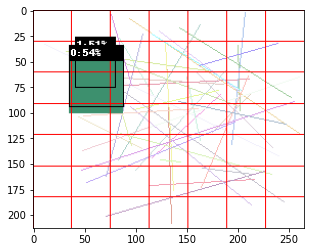

In [28]:
img_pil, bbox_true = create_image(1)
img_pil, bbox_predict = predict(model, img_pil, transformer, prob_threshold=0.2, print_grid=True)
imshow(img_pil)
print (bbox_predict)